![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 5 - PyTorch</center>
### <center> Cifar-10 Example </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/05_PyTorch/MainPyTorchCifar.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
#-- Imports:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

#-- torch:
import torch
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
import torchsummary

matplotlib.rc('font', **{'size' : 16})

# #-- Fix seed (for presentation sake)
# torch.manual_seed(0)
# np.random.seed   (0)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark     = False

#### Accuracy function
A `torch.tensor` stores the computational graph.  
Use `torch.Tensor.item()` to get a Python number from a tensor containing a single value.

In [4]:
#-- Example for item():
x = torch.tensor(5.3)
x, x.item()

(tensor(5.3000), 5.300000190734863)

In [5]:
#-- Classification accuracy:
def Accuracy(mScore, vY):
    vHatY = mScore.detach().argmax(dim=1)
    return (vHatY == vY).float().mean().item()

In [6]:
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU

    oModel.train(bTrain) #-- train or test
    
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(DEVICE)
        vY = vY.to(DEVICE)
        
        #-- Forward:
        if bTrain == True:
            #-- Store computational graph:
            mZ   = oModel(mX)
            loss = Loss(mZ, vY)
        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                mZ   = oModel(mX)
                loss = Loss(mZ, vY)

        #-- Backward:
        if bTrain == True:
            oOptim.zero_grad() #-- set gradients to zeros
            loss.backward()    #-- backward
            oOptim.step()      #-- update parameters

        Nb           = vY.shape[0]
        count       += Nb
        epochLoss   += Nb * loss.item()
        epochMetric += Nb * Metric(mZ, vY)
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:.6f}', end='')

    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric

In [7]:
import time

def TrainClassficationModel(oModel, oTrainData, oValData, Loss, nEpochs, oOptim):

    vTrainLoss = np.full(nEpochs, np.nan)
    vTrainAcc  = np.full(nEpochs, np.nan)
    vValLoss   = np.full(nEpochs, np.nan)
    vValAcc    = np.full(nEpochs, np.nan)
    bestAcc    = 0

    for epoch in range(nEpochs):
        startTime = time.time()
        trainLoss, trainAcc = Epoch(oModel, oTrainData, Loss, Accuracy, oOptim, bTrain=True ) #-- train
        valLoss,   valAcc   = Epoch(oModel, oValData,   Loss, Accuracy,         bTrain=False) #-- validate
        epochTime = time.time() - startTime

        #-- Display:
        print('Epoch '              f'{epoch    :03d}:',   end='')
        print(' | Train loss: '     f'{trainLoss:.5f}' ,   end='')
        print(' | Val loss: '       f'{valLoss  :.5f}' ,   end='')
        print(' | Train Accuracy: ' f'{trainAcc :2.4f}',   end='')
        print(' | Val Accuracy: '   f'{valAcc   :2.4f}',   end='')
        print(' | epoch time: '     f'{epochTime:3.3f} |', end='')

        vTrainLoss[epoch] = trainLoss
        vTrainAcc [epoch] = trainAcc
        vValLoss  [epoch] = valLoss
        vValAcc   [epoch] = valAcc

        #-- Save best model (early stopping):
        if bestAcc < valAcc:
            bestAcc = valAcc
            try:
                torch.save(oModel.state_dict(), 'BestModel.pt')
            except:
                pass
            print(' <-- Checkpoint!')
        else:
            print('')

    #-- Load best model (early stopping):
    oModel.load_state_dict(torch.load('BestModel.pt'))

    return vTrainLoss, vTrainAcc, vValLoss, vValAcc

### Download CIFAR-10 dataset:

In [8]:
import torchvision
import torchvision.transforms as transforms

oTrainSet = torchvision.datasets.CIFAR10(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.CIFAR10(root='../../data', train=False, download=True, transform=transforms.ToTensor())
lClasses  = oTrainSet.classes

oTrainSet.data.shape, oTrainSet[0][0].shape

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), torch.Size([3, 32, 32]))

### Plot some examples:

In [9]:
oTrainSet.data.shape, oTrainSet[0][0].shape

((50000, 32, 32, 3), torch.Size([3, 32, 32]))

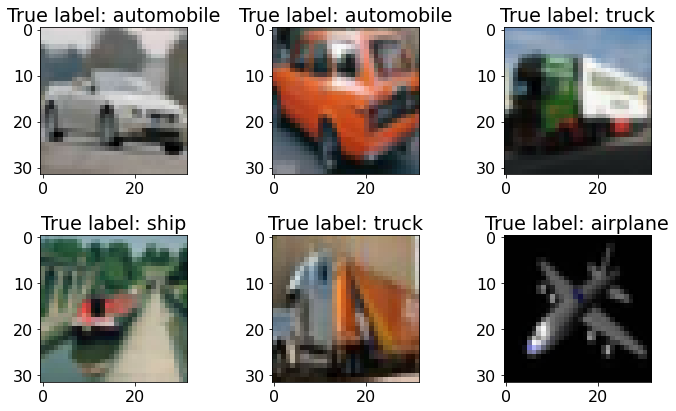

In [10]:
N, H, W, C = oTrainSet.data.shape
fig, _     = plt.subplots(2, 3, figsize=(10,6))
for ax in fig.axes:
    idx   = np.random.randint(N)
    mX, y = oTrainSet[idx]
    ax.imshow(np.transpose(mX.numpy(), (1,2,0)))
    ax.set_title(f'True label: {lClasses[y]}')
    
plt.tight_layout()
plt.show()

#### Compute mean and variance:

In [11]:
vMean = oTrainSet.data.mean((0,1,2)) / 255
vStd  = oTrainSet.data.std ((0,1,2)) / 255
print('µ =', vMean)
print('σ =', vStd)

µ = [0.49139968 0.48215841 0.44653091]
σ = [0.24703223 0.24348513 0.26158784]


#### Add normalization to the datasets (using `transform`):

In [12]:
oTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(vMean, vStd)
])

oTrainSet.transform = oTransform
oTestSet .transform = oTransform

#### Create data loaders:

In [13]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2)

### Define the model (architecture):

In [14]:
def GetModel():
    oModel = nn.Sequential(
        nn.Identity(), #-- does nothing
        nn.Flatten (),
        
        nn.Linear(3*32*32, 500), nn.ReLU(),
        nn.Linear(500,     250), nn.ReLU(),
        nn.Linear(250,      10)
    )
    return oModel

torchsummary.summary(GetModel(), (C, H, W), device='cpu');

Layer (type:depth-idx)                   Output Shape              Param #
├─Identity: 1-1                          [-1, 3, 32, 32]           --
├─Flatten: 1-2                           [-1, 3072]                --
├─Linear: 1-3                            [-1, 500]                 1,536,500
├─ReLU: 1-4                              [-1, 500]                 --
├─Linear: 1-5                            [-1, 250]                 125,250
├─ReLU: 1-6                              [-1, 250]                 --
├─Linear: 1-7                            [-1, 10]                  2,510
Total params: 1,664,260
Trainable params: 1,664,260
Non-trainable params: 0
Total mult-adds (M): 1.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 6.35
Estimated Total Size (MB): 6.37


### Check whether GPU is available:

In [15]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
DEVICE

device(type='cuda', index=0)

### Train the model:

In [16]:
oModel  = GetModel().to(DEVICE)
Loss    = nn.CrossEntropyLoss()
oOptim  = optim.AdamW(oModel.parameters(), lr=1e-4, betas=(0.9, 0.99), weight_decay=1e-4)
nEpochs = 20

TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim);

Epoch 000: | Train loss: 1.70304 | Val loss: 1.54404 | Train Accuracy: 0.4009 | Val Accuracy: 0.4632 | epoch time: 10.958 | <-- Checkpoint!
Epoch 001: | Train loss: 1.48330 | Val loss: 1.44708 | Train Accuracy: 0.4811 | Val Accuracy: 0.4932 | epoch time: 12.168 | <-- Checkpoint!
Epoch 002: | Train loss: 1.38320 | Val loss: 1.41071 | Train Accuracy: 0.5194 | Val Accuracy: 0.5059 | epoch time: 11.420 | <-- Checkpoint!
Epoch 003: | Train loss: 1.30908 | Val loss: 1.37224 | Train Accuracy: 0.5466 | Val Accuracy: 0.5172 | epoch time: 11.422 | <-- Checkpoint!
Epoch 004: | Train loss: 1.24891 | Val loss: 1.35288 | Train Accuracy: 0.5684 | Val Accuracy: 0.5260 | epoch time: 11.300 | <-- Checkpoint!
Epoch 005: | Train loss: 1.19178 | Val loss: 1.34475 | Train Accuracy: 0.5885 | Val Accuracy: 0.5275 | epoch time: 11.239 | <-- Checkpoint!
Epoch 006: | Train loss: 1.14082 | Val loss: 1.32762 | Train Accuracy: 0.6084 | Val Accuracy: 0.5301 | epoch time: 10.674 | <-- Checkpoint!
Epoch 007: | Train l

### Exercise:
* Use the California housing dataset `fetch_california_housing`.
* Use MSE loss (instead of the cross-entropy)
* Replace the classification accuracy with $R^2$ score.
* Try to get the best MSE\R2 score you can.

**Tips**:
* You should test different models (layers\activations) and hyper-parameters.
* Try different optimizers and regularizations.
* $R_2 > 0.8$ (on the validation set) is quite good.

In [17]:
from sklearn.datasets import fetch_california_housing

mX, vY  = fetch_california_housing(return_X_y=True)
mX     -= mX.mean(0)
mX     /= mX.std (0)

mX.shape, vY.shape

((20640, 8), (20640,))

In [18]:
from torch.utils.data import TensorDataset

nTrain              = 15000
nTest               = 5640
oDataset            = TensorDataset(torch.tensor(mX, dtype=torch.float32), torch.tensor(vY, dtype=torch.float32))
oTrainSet, oValSet  = torch.utils.data.random_split(oDataset, [nTrain, nTest])
len(oTrainSet), len(oValSet)

(15000, 5640)

#### $R^2$ function
`tensor.detach()` creates a tensor that shares storage with `tensor` that does not require grad.

In [19]:
from sklearn.metrics import r2_score

def R2Score(vHatY, vY):
    vY    = vY   .detach().cpu().view(-1)
    vHatY = vHatY.detach().cpu().view(-1)
    return ???

In [20]:
import time

def TrainRegressionModel(oModel, oTrainData, oValData, Loss, nEpochs, oOptim):

    vTrainLoss = np.full(nEpochs, np.nan)
    vTrainR2   = np.full(nEpochs, np.nan)
    vValLoss   = np.full(nEpochs, np.nan)
    vValR2     = np.full(nEpochs, np.nan)
    bestR2     = 0

    for epoch in range(nEpochs):
        startTime = time.time()
        trainLoss, trainR2 = Epoch(oModel, oTrainData, ???, ???, oOptim, bTrain=True ) #-- train
        valLoss,   valR2   = Epoch(oModel, oValData,   ???, ???,         bTrain=False) #-- validate
        epochTime = time.time() - startTime

        #-- Display:
        print('Epoch '          f'{epoch    :03d}:',   end='')
        print(' | Train loss: ' f'{trainLoss:.5f}' ,   end='')
        print(' | Val loss: '   f'{valLoss  :.5f}' ,   end='')
        print(' | Train R2: '   f'{trainR2 :+2.4f}',   end='')
        print(' | Val R2: '     f'{valR2   :+2.4f}',   end='')
        print(' | epoch time: ' f'{epochTime:3.3f} |', end='')

        vTrainLoss[epoch] = trainLoss
        vTrainR2  [epoch] = trainR2
        vValLoss  [epoch] = valLoss
        vValR2    [epoch] = valR2

        #-- Save best model (early stopping):
        if ??? < ???:
            ??? = ???
            try:
                torch.save(oModel.state_dict(), 'BestModel.pt')
            except:
                pass
            print(' <-- Checkpoint!')
        else:
            print('')

    #-- Load best model (early stopping):
    oModel.load_state_dict(torch.load('BestModel.pt'))

    return vTrainLoss, vTrainR2, vValLoss, vValR2

In [21]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2)
oValDL    = torch.utils.data.DataLoader(oValSet,   shuffle=False, batch_size=2*batchSize, num_workers=2)

In [1]:
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
import torchsummary

#-- Tensor to vector (reshape):
class Squeeze(nn.Module):
    def forward(self, mX):
        return mX[:,0]

#-- Model:
def GetModel():
    oModel = nn.Sequential(
        nn.Identity(),  #-- does nothing
        ???
        
        Squeeze()
    )
   
    return oModel

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
torchsummary.summary(GetModel(), (8,), device='cpu');

SyntaxError: invalid syntax (<ipython-input-1-4d2555473a8c>, line 15)

In [23]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
DEVICE

device(type='cuda', index=0)

In [24]:
oModel  = GetModel().to(DEVICE)
Loss    = ???
oOptim  = ???
nEpochs = 150

TrainRegressionModel(oModel, oTrainDL, oValDL, Loss, nEpochs, oOptim);

Epoch 000: | Train loss: 1.40575 | Val loss: 0.98158 | Train R2: -0.0723 | Val R2: +0.2694 | epoch time: 2.404 | <-- Checkpoint!
Epoch 001: | Train loss: 0.86331 | Val loss: 0.61450 | Train R2: +0.3420 | Val R2: +0.5385 | epoch time: 2.461 | <-- Checkpoint!
Epoch 002: | Train loss: 1.09707 | Val loss: 1.04488 | Train R2: +0.1687 | Val R2: +0.2174 | epoch time: 2.635 |
Epoch 003: | Train loss: 1.58837 | Val loss: 3.04303 | Train R2: -0.4952 | Val R2: -1.2734 | epoch time: 2.986 |
Epoch 004: | Train loss: 2.02782 | Val loss: 0.71811 | Train R2: -0.3409 | Val R2: +0.4616 | epoch time: 2.787 |
Epoch 005: | Train loss: 1.59696 | Val loss: 0.70818 | Train R2: -0.0860 | Val R2: +0.4692 | epoch time: 2.538 |
Epoch 006: | Train loss: 2.06670 | Val loss: 0.78344 | Train R2: -0.7312 | Val R2: +0.4132 | epoch time: 2.587 |
Epoch 007: | Train loss: 3.60828 | Val loss: 0.35537 | Train R2: -1.9025 | Val R2: +0.7328 | epoch time: 2.592 | <-- Checkpoint!
Epoch 008: | Train loss: 1.07305 | Val loss: 0.3

Epoch 142: | Train loss: 0.15952 | Val loss: 0.27075 | Train R2: +0.8781 | Val R2: +0.7954 | epoch time: 2.378 |
Epoch 143: | Train loss: 0.15981 | Val loss: 0.26389 | Train R2: +0.8779 | Val R2: +0.8008 | epoch time: 2.404 |
Epoch 144: | Train loss: 0.16549 | Val loss: 0.26886 | Train R2: +0.8719 | Val R2: +0.7968 | epoch time: 2.444 |
Epoch 145: | Train loss: 0.16057 | Val loss: 0.27176 | Train R2: +0.8773 | Val R2: +0.7951 | epoch time: 2.394 |
Epoch 146: | Train loss: 0.15842 | Val loss: 0.26928 | Train R2: +0.8788 | Val R2: +0.7966 | epoch time: 2.405 |
Epoch 147: | Train loss: 0.16234 | Val loss: 0.26623 | Train R2: +0.8758 | Val R2: +0.7985 | epoch time: 2.584 |
Epoch 148: | Train loss: 0.15620 | Val loss: 0.25228 | Train R2: +0.8804 | Val R2: +0.8096 | epoch time: 2.695 |
Epoch 149: | Train loss: 0.15880 | Val loss: 0.27064 | Train R2: +0.8778 | Val R2: +0.7950 | epoch time: 2.740 |


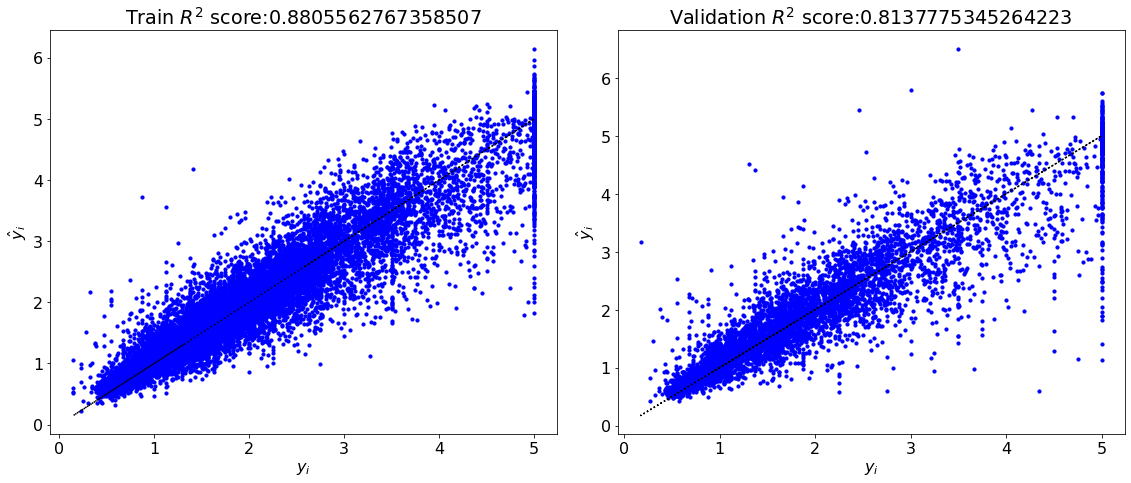

In [25]:
from torch.utils.data import DataLoader
from sklearn.metrics  import r2_score

#-- Entire dataset in one batch:
mTrainX, vTrainY = next(iter(DataLoader(oTrainSet, shuffle=False, batch_size=nTrain)))
mValX,   vValY   = next(iter(DataLoader(oValSet,   shuffle=False, batch_size=nTest )))

#-- Apply model to data:
with torch.no_grad():
    vHatTrainY = oModel(mTrainX.to(DEVICE)).detach().cpu()
    vHatValY   = oModel(mValX  .to(DEVICE)).detach().cpu()

_, ax = plt.subplots(1, 2, figsize=(16, 7))

ax[0].scatter   (vTrainY, vHatTrainY, s=10, c='b', edgecolor=None)
ax[1].scatter   (vValY,   vHatValY,  s=10, c='b', edgecolor=None)
ax[0].plot      (vTrainY, vTrainY, ':k')
ax[1].plot      (vValY,   vValY,   ':k')
ax[0].set_title ('Train $R^2$ score:'      f'{r2_score(vTrainY, vHatTrainY)}')
ax[1].set_title ('Validation $R^2$ score:' f'{r2_score(vValY,   vHatValY)}')
ax[0].set_xlabel('$y_i$')
ax[1].set_xlabel('$y_i$')
ax[0].set_ylabel('$\hat{y}_i$')
ax[1].set_ylabel('$\hat{y}_i$')

plt.tight_layout()
plt.show        ()